# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**ТЗ**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
- Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Инструкция по выполнению проекта

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг. 
Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.


Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки переда
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Подготовка данных

In [1]:
!pip install scikit-learn==1.1.3

In [2]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
cols_to_rename = df.columns.str.lower()

cols = {}
for key, val in zip(df.columns, cols_to_rename):
    cols.update({key: val})
    
df = df.rename(columns=cols)
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.shape

(354369, 16)

In [6]:
df.isna().sum()

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
repaired             71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

**Много пропусков в категориальных признаках**

Будет правильным заполнить их категорией Unknown

In [7]:
df[['vehicletype', 'gearbox', 'model', 'fueltype', 'repaired',]] = \
df[['vehicletype', 'gearbox', 'model', 'fueltype', 'repaired',]].fillna('unknown')
df.isna().sum()

datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
repaired             0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        354369 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            354369 non-null  object
 5   power              354369 non-null  int64 
 6   model              354369 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           354369 non-null  object
 10  brand              354369 non-null  object
 11  repaired           354369 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

**Типы данных приведены в порядок**

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registrationyear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registrationmonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
numberofpictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postalcode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [10]:
df.duplicated().sum()

4

In [11]:
df = df.drop_duplicates()
df.shape

(354365, 16)

**Удалены 4 дубликата**

In [12]:
# Нам не понадобятся для анализаи обучения моделей некоторые столбцы

df.drop(['datecrawled', 'datecreated', 'postalcode', 'lastseen', 'registrationmonth'], axis=1, inplace=True)

In [13]:
# Тут мы приведём к булиеву типу 0 или 1

df.loc[(df['repaired'] == 'yes'), 'repaired'] = 1
df.loc[(df['repaired'] == 'no'), 'repaired'] = 0
df['repaired'] = df['repaired'].fillna(1).astype(bool)
df['repaired'].value_counts()

False    247158
True     107207
Name: repaired, dtype: int64

### EDA

In [14]:
def distribution(field):
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df[field], kde=True, alpha=0.5)
    plt.title(f'Распределение по {field}')
    plt.xlabel(f'Распределение {field}')
    plt.ylabel('Величина')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df[field])
    plt.title(f'Boxplot по {field}')
    plt.xlabel(f'Распределение {field}')
    plt.ylabel('Размах')
    plt.show()

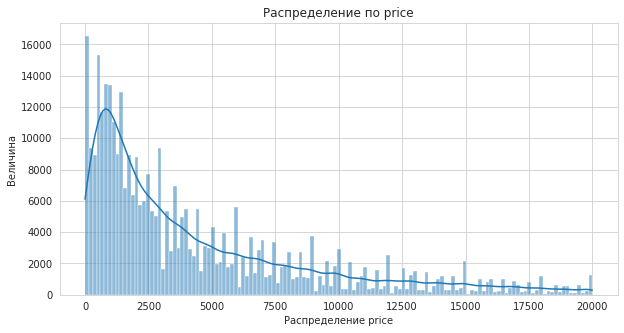

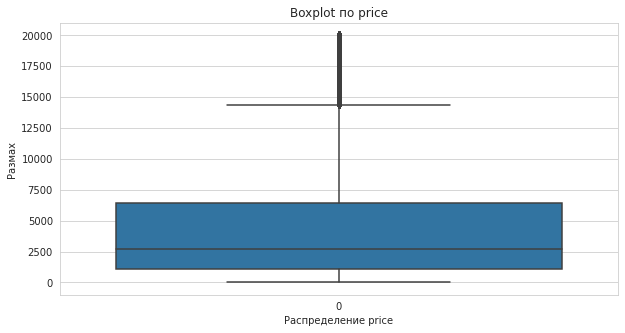

In [15]:
distribution('price')

In [16]:
df = df.loc[df['price'] > 100]

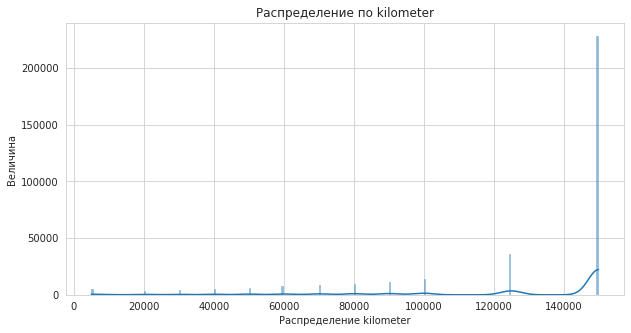

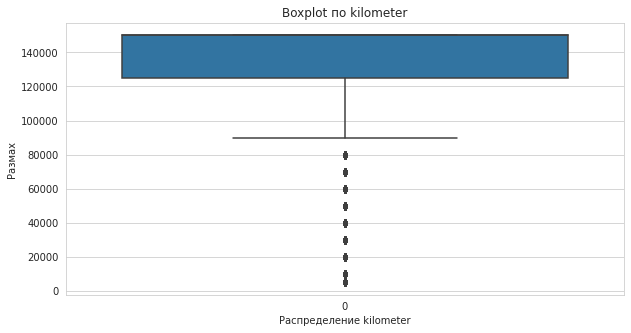

In [17]:
distribution('kilometer')

<Figure size 720x360 with 0 Axes>

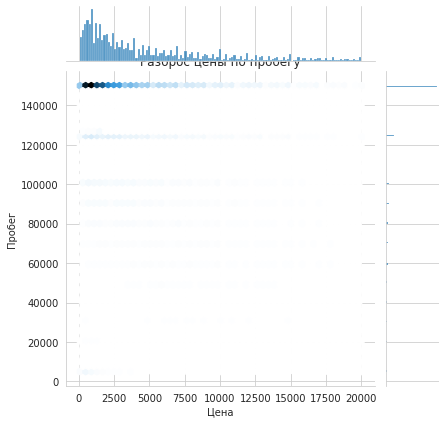

In [18]:
plt.figure(figsize=(10, 5))
sns.jointplot(x=df['price'], y=df['kilometer'], kind='hex')
plt.title('Разброс цены по пробегу')
plt.xlabel('Цена')
plt.ylabel('Пробег')
plt.show()

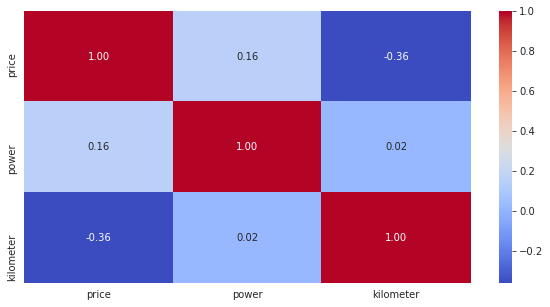

In [19]:
corr_matrix = df[['price', 'power', 'kilometer']].corr()

plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

**Промежуточный вывод**

- Большинство машин продаются по цене 2-7 тысяч евро
- Большинство машин имеют пробег 100-150 тысяч км
- Между ценой и мощностью двигателя есть небольшая корреляция
- Между ценой и пробегом есть умеренная обратная корреляция (чем больше пробег, тем меньше цена)

In [20]:
def barplot_creator(field):
    
    value_counts = df[field].value_counts().sort_values(ascending=False)
    
    plt.figure(figsize=(15, 5))
    sns.countplot(x=df[field], alpha=0.5, order=value_counts.index)
    plt.title(f'Количество {field}')
    plt.xlabel(f'{field}')
    plt.xticks(rotation=45)
    plt.ylabel('Величина')
    plt.show()

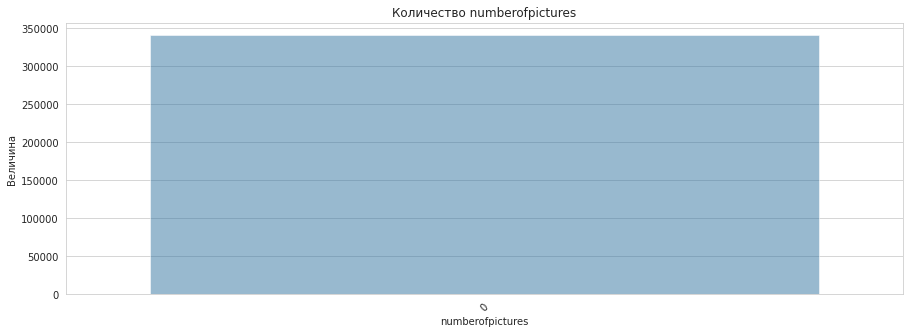

In [21]:
barplot_creator('numberofpictures')

In [22]:
df['numberofpictures'].value_counts()

0    340020
Name: numberofpictures, dtype: int64

Фотографий у объявлений нет, значит, столбец можно удалить

In [23]:
df.drop(['numberofpictures'], axis=1, inplace=True)

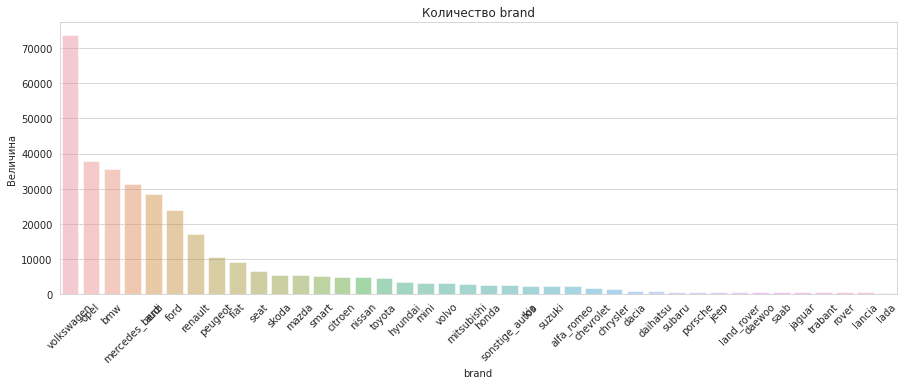

In [24]:
barplot_creator('brand')

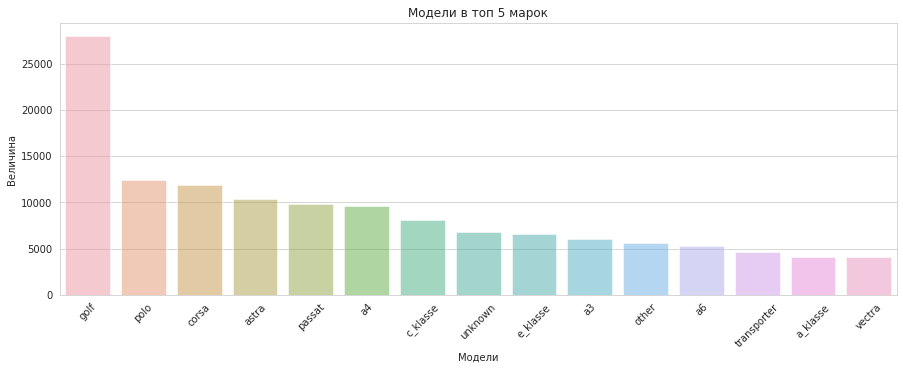

In [25]:
top_5_brands = df[df['brand'].isin(['volkswagen', 'opel', 'bmv', 'mercedes_benz', 'audi'])]


value_counts = top_5_brands['model'].value_counts().sort_values(ascending=False)[:15]

plt.figure(figsize=(15, 5))
sns.countplot(x=top_5_brands['model'], alpha=0.5, order=value_counts.index)
plt.title(f'Модели в топ 5 марок')
plt.xlabel(f'Модели')
plt.xticks(rotation=45)
plt.ylabel('Величина')
plt.show()

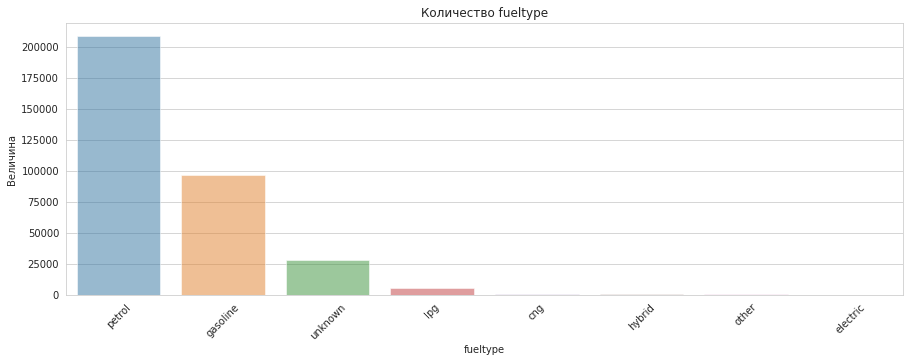

In [26]:
barplot_creator('fueltype')

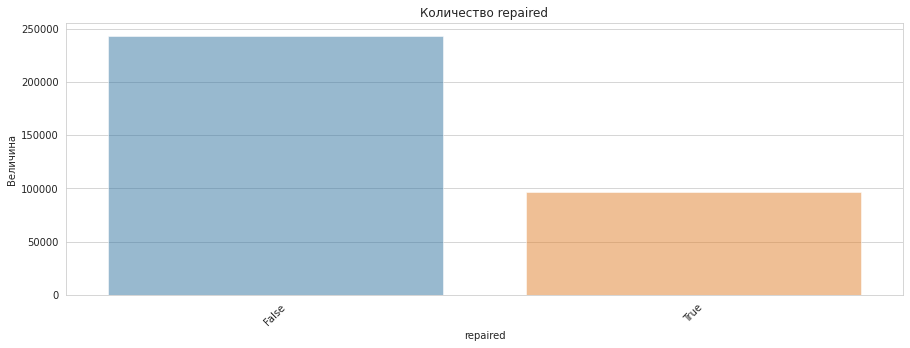

In [27]:
barplot_creator('repaired')

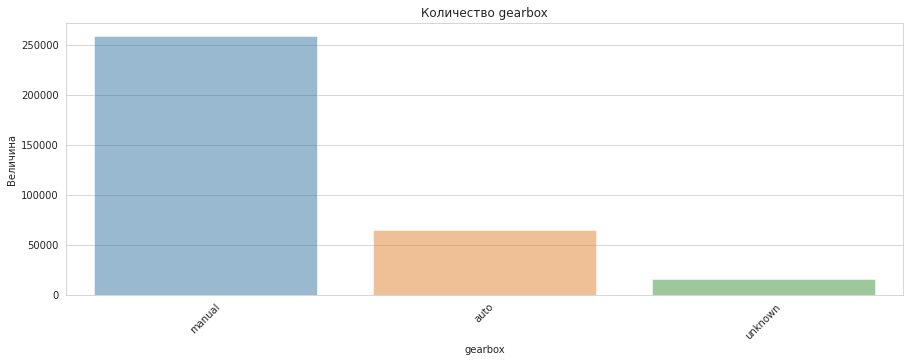

In [28]:
barplot_creator('gearbox')

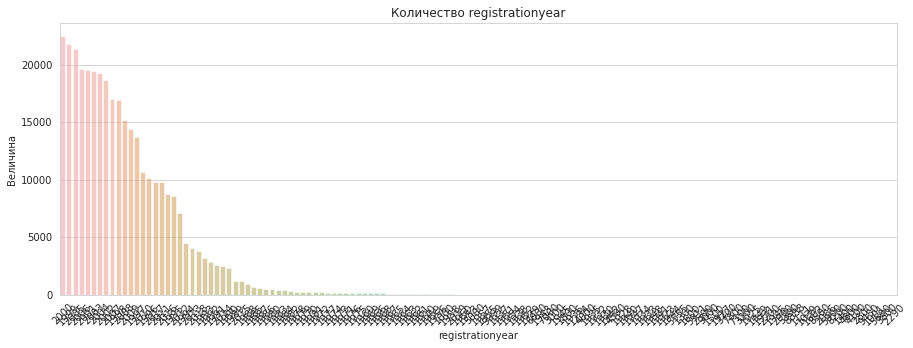

In [29]:
barplot_creator('registrationyear')

Нечитайемый график, да и слишком далеко от уходит в прошлое, поэтому обрежем данные до 1980 года

In [30]:
df = df.loc[df['registrationyear'] >= 1980]
df = df.loc[df['registrationyear'] <= 2016]
df.shape

(323290, 10)

<div class="alert alert-info">
Исправил
</div>

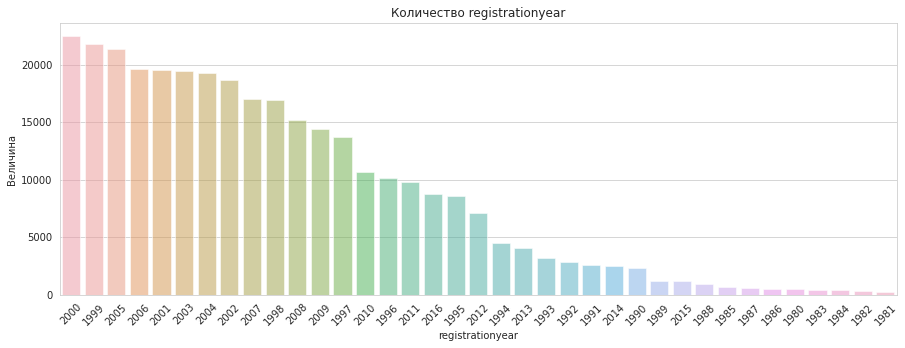

In [31]:
barplot_creator('registrationyear')

**Общий вывод по EDA**

- Наиболее популярны машины из Германии, США и Франции
- Первые 5 объявлений по популярности занимают немецкие марки: Volkswagen, Opel, BMW, Mersedes Benz, Audi
- Далее идут Ford (USA), Renault, Peugeot (FR, FR)
- Наиболее популярны легковые модели
- Значительно меньшую популярность имеют марки из Восточной Европы, России и Азии
- Подавляющее большинство испоьзует Petrol/gasoline в качестве топлива


- Увеличение пробега снижает стоимость автомобиля
- Мощность двигателя с ростом немного повышает стоимость автомобиля
- Большинство машин продаются по цене 2-7 тысяч евро
- Большинство машин имеют пробег 100-150 тысяч км
- Больнитсво машин не ремонтировались
- Больнитсво машин имеют механическую коробку передач и около 1/6 – автомат

## Обучение моделей

### Подготовка признаков

In [32]:
df.columns

Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'fueltype', 'brand', 'repaired'],
      dtype='object')

In [33]:
features = df.drop('price', axis=1)
target = df['price']

cat_features = ['brand', 'model', 'vehicletype', 'gearbox', 'fueltype', 'power', 'kilometer']

In [34]:
X_train, X, y_train, y = train_test_split(features, 
                                           target, 
                                           random_state=42, 
                                           test_size=0.5)

X_test, X_valid, y_test, y_valid = train_test_split(X, 
                                                    y, 
                                                    random_state=42, 
                                                    test_size=0.5)

print(f'X_train: {X_train.shape}\n'
      f'X_test: {X_test.shape}\n'
      f'X_valid: {X_valid.shape}\n'
      f'y_train: {y_train.shape}\n'
      f'y_test: {y_test.shape}\n'
      f'y_validt: {y_valid.shape}')

X_train: (161645, 9)
X_test: (80822, 9)
X_valid: (80823, 9)
y_train: (161645,)
y_test: (80822,)
y_validt: (80823,)


In [35]:
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

encoder.fit(X_train)

X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)
X_valid_encoded = encoder.transform(X_valid)

In [36]:
scaler = StandardScaler(with_mean=False)

scaler.fit(X_train_encoded)

X_train_scaled = scaler.transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X_valid_scaled = scaler.transform(X_valid_encoded)

### Модели

#### Каскадная модель

Нужна для того, чтобы обозначить максимально допустимую величину метрики и чтобы убедиться, что в обучении алгоритмов в дальнейшем есть смысл

In [37]:
%time
cascad_model = DummyRegressor(strategy='mean')
cascad_model.fit(X_train_scaled, y_train)

y_pred_cascad = cascad_model.predict(X_valid)
cascad_MSE = mean_squared_error(y_valid, y_pred_cascad)
print(math.sqrt(cascad_MSE))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
4496.109437686281


#### Линейная регрессия

In [38]:
%time
reg_model = LinearRegression()
reg_model.fit(X_train_scaled, y_train)

y_pred_reg = reg_model.predict(X_valid_scaled)
reg_MSE = mean_squared_error(y_valid, y_pred_reg)
print(math.sqrt(reg_MSE))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs
1981.368169793703


#### Градиентный бустинг с Catboost

In [39]:
# CatBoost

%time
for i in range(1, 6):
    model_catboost = CatBoostRegressor(loss_function='RMSE', iterations=20, depth=i)
    model_catboost.fit(X_train, y_train, cat_features=cat_features)
    y_pred_catboost = model_catboost.predict(X_valid)
    
    catboost_MSE = mean_squared_error(y_valid, y_pred_catboost)
    print(math.sqrt(catboost_MSE))

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.34 µs
Learning rate set to 0.5
0:	learn: 3850.2330551	total: 90.1ms	remaining: 1.71s
1:	learn: 3602.5033821	total: 113ms	remaining: 1.02s
2:	learn: 3436.7541633	total: 142ms	remaining: 807ms
3:	learn: 3171.0789099	total: 172ms	remaining: 687ms
4:	learn: 3064.6480461	total: 215ms	remaining: 644ms
5:	learn: 2972.2137232	total: 244ms	remaining: 568ms
6:	learn: 2892.7707393	total: 273ms	remaining: 507ms
7:	learn: 2822.4962724	total: 299ms	remaining: 449ms
8:	learn: 2762.8897599	total: 326ms	remaining: 399ms
9:	learn: 2718.2265219	total: 351ms	remaining: 351ms
10:	learn: 2661.1513595	total: 379ms	remaining: 310ms
11:	learn: 2629.9748792	total: 407ms	remaining: 271ms
12:	learn: 2599.7121248	total: 428ms	remaining: 231ms
13:	learn: 2572.6521530	total: 450ms	remaining: 193ms
14:	learn: 2550.0296052	total: 471ms	remaining: 157ms
15:	learn: 2527.0072528	total: 492ms	remaining: 123ms
16:	learn: 2507.0809785	total: 514ms	remaining: 90.8ms
1

#### Градиентный бустинг с LightGBM

In [40]:
# LightGBM

metrics = {}
%time
for i in range(1, 5):
    model_lgbm = LGBMRegressor(n_jobs=i)
    model_lgbm.fit(X_train_encoded, y_train)
    y_pred_lgbm = model_lgbm.predict(X_valid_encoded)
    lgbm_MSE = mean_squared_error(y_valid, y_pred_lgbm)
    metrics.update({math.sqrt(lgbm_MSE) : i})
    print(f'MSE: {math.sqrt(lgbm_MSE)}. Number of iterations {i}')

        
min_key = min(metrics, key=lambda k: metrics[k])

min_item = {min_key: metrics[min_key]}
print(min_item)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
MSE: 1896.1967626506664. Number of iterations 1
MSE: 1896.1967626506664. Number of iterations 2
MSE: 1896.1967626506664. Number of iterations 3
MSE: 1896.1967626506664. Number of iterations 4
{1896.1967626506664: 4}


#### GradientBoostingRegressor

In [41]:
for i in range(1, 6):
    for j in range(1, 6):
        gb_model = GradientBoostingRegressor(loss='ls', 
                                             n_estimators=i,
                                             max_depth=j)
        gb_model.fit(X_train_encoded, y_train)
        y_pred_gb = gb_model.predict(X_valid_encoded)
        mse_gb = mean_squared_error(y_valid, y_pred_gb)
        print(f'RMSE: {math.sqrt(mse_gb)}, estimators: {i}, depth: {j}')

RMSE: 4443.755858018733, estimators: 1, depth: 1
RMSE: 4385.506039225644, estimators: 1, depth: 2
RMSE: 4358.488508620953, estimators: 1, depth: 3
RMSE: 4332.723085787908, estimators: 1, depth: 4
RMSE: 4312.999119030347, estimators: 1, depth: 5
RMSE: 4400.916456902747, estimators: 2, depth: 1
RMSE: 4292.399641453451, estimators: 2, depth: 2
RMSE: 4243.261491655265, estimators: 2, depth: 3
RMSE: 4195.484983806231, estimators: 2, depth: 4
RMSE: 4157.208712703795, estimators: 2, depth: 5
RMSE: 4358.496029566976, estimators: 3, depth: 1
RMSE: 4213.692644362823, estimators: 3, depth: 2
RMSE: 4140.473669679964, estimators: 3, depth: 3
RMSE: 4078.071899311677, estimators: 3, depth: 4
RMSE: 4022.8733961626704, estimators: 3, depth: 5
RMSE: 4321.977432533526, estimators: 4, depth: 1
RMSE: 4155.356827926711, estimators: 4, depth: 2
RMSE: 4055.5693398488584, estimators: 4, depth: 3
RMSE: 3975.7672291639856, estimators: 4, depth: 4
RMSE: 3907.6112002315695, estimators: 4, depth: 5
RMSE: 4285.96068

Здесь метрика недопустимо большая

**Вывод**

Мы рассмотрели 5 моделей:
- DummyRegressor
- LinearRegression
- Catboost
- LightGBM
- GradientBoostingRegressor

каскажная модель и последняя показали слишком высокую метрику, поэтому будем рассматривать 2-4

## Анализ моделей

Мы подобрали оптимальные гиперпараметры для моделей, теперь проверим их на переобучаемость, а также оценим время их обучения и предсказания

In [42]:
reg_model = LinearRegression()
%time reg_model.fit(X_train_scaled, y_train)
%time reg_y_pred = reg_model.predict(X_valid_scaled)
reg_MSE = mean_squared_error(y_valid, reg_y_pred)
print(math.sqrt(reg_MSE))

CPU times: user 4.85 s, sys: 6.38 s, total: 11.2 s
Wall time: 11.2 s
CPU times: user 11.2 ms, sys: 3.38 ms, total: 14.6 ms
Wall time: 2.56 ms
1981.368169793703


In [43]:
model_catboost = CatBoostRegressor(loss_function='RMSE', iterations=20, depth=5)
%time model_catboost.fit(X_train, y_train, cat_features=cat_features)
%time y_pred_catboost = model_catboost.predict(X_valid)
catboost_MSE = mean_squared_error(y_valid, y_pred_catboost)
print(math.sqrt(catboost_MSE))

Learning rate set to 0.5
0:	learn: 3348.0801389	total: 74.5ms	remaining: 1.42s
1:	learn: 2792.6066897	total: 138ms	remaining: 1.24s
2:	learn: 2514.0595259	total: 199ms	remaining: 1.13s
3:	learn: 2301.1935996	total: 253ms	remaining: 1.01s
4:	learn: 2220.0407430	total: 306ms	remaining: 918ms
5:	learn: 2165.1805635	total: 365ms	remaining: 851ms
6:	learn: 2132.3826235	total: 420ms	remaining: 779ms
7:	learn: 2097.3105557	total: 472ms	remaining: 709ms
8:	learn: 2075.0951438	total: 524ms	remaining: 641ms
9:	learn: 2050.4814676	total: 577ms	remaining: 577ms
10:	learn: 2033.8580207	total: 631ms	remaining: 516ms
11:	learn: 2024.4441577	total: 685ms	remaining: 457ms
12:	learn: 2007.2522622	total: 739ms	remaining: 398ms
13:	learn: 1996.8783553	total: 795ms	remaining: 341ms
14:	learn: 1984.8952440	total: 844ms	remaining: 281ms
15:	learn: 1971.8054990	total: 894ms	remaining: 223ms
16:	learn: 1966.4285724	total: 943ms	remaining: 166ms
17:	learn: 1960.0454790	total: 995ms	remaining: 111ms
18:	learn: 1

In [44]:
model_lgbm = LGBMRegressor(n_jobs=4)
%time model_lgbm.fit(X_train_encoded, y_train)
%time y_pred_lgbm = model_lgbm.predict(X_valid_encoded)
lgbm_MSE = mean_squared_error(y_valid, y_pred_lgbm)
print(math.sqrt(lgbm_MSE))

CPU times: user 2.24 s, sys: 0 ns, total: 2.24 s
Wall time: 2.23 s
CPU times: user 677 ms, sys: 0 ns, total: 677 ms
Wall time: 700 ms
1896.1967626506664


Самой быстрой моделью, хоть и с немного большей метрикой, оказалась модель Catboost. Проверим её на переобучаемость

In [45]:
pred_valid = model_catboost.predict(X_valid)
MSE_valid = mean_squared_error(y_valid, pred_valid)

pred_test = model_catboost.predict(X_test)
MSE_test = mean_squared_error(y_test, pred_test)

print(f'RMSE train: {math.sqrt(MSE_valid)}\n'
      f'RMSE test: {math.sqrt(MSE_test)}')

RMSE train: 1935.820560381317
RMSE test: 1949.5832038340016


Метрики близки, следовательно, модель не склонна к переобучению: разница в метрике всего ≈0.7%

**Общий вывод**

- Мы получили данные о продаже автомобилей с пробегом
- Данные были предобработаны: устранены аномалии, пропуски, а также удалены ненужные поля
- В ходе разведочного анализа выянслось, что:
    - Наиболее популярны машины из Германии, США и Франции
    - Первые 5 объявлений по популярности занимают немецкие марки: Volkswagen, Opel, BMW, Mersedes Benz, Audi
    - Далее идут Ford (USA), Renault, Peugeot (FR, FR)
    - Наиболее популярны легковые модели
    - Значительно меньшую популярность имеют марки из Восточной Европы, России и Азии
    - Подавляющее большинство испоьзует Petrol/gasoline в качестве топлива


    - Увеличение пробега снижает стоимость автомобиля
    - Мощность двигателя с ростом немного повышает стоимость автомобиля
    - Большинство машин продаются по цене 2-7 тысяч евро
    - Большинство машин имеют пробег 100-150 тысяч км
    - Больнитсво машин не ремонтировались
    - Больнитсво машин имеют механическую коробку передач и около 1/6 – автомат


- На полученном датасете были обучены модели, решиющие задачу регрессии:
    - Каскадная модель DummyRegressor
    - LinearRegressor
    - CatBoostRegressor
    - LGBMRegressor
    - GradientBoostRegressor

- Приемлимую для заказчика метрику получили модели  LinearRegressor, CatBoostRegressor, LGBMRegressor. Следующим приоритетом была оценка времени обучения и предсказания модели. Наиболее быстрой моделью оказалась CatBoostRegressor, общее время обучения которой 3.2 секунды
- Итоговая модель была проверена на переобучение: склонность к переобучению не выявлена.